In [16]:
# # autoreload 
# %load_ext autoreload
# %autoreload 2
import argparse
import json
import os
import warnings
import sys

sys.path.append("../")

import pandas as pd
from sklearn.metrics import r2_score

# print sys.path
print(sys.path)
from domains.samplers import SyntheticDataSampler
from models.MoE import *
from models.utils import *
from models.additive_parallel_comp_model import get_additive_model_effects
warnings.filterwarnings('ignore')

def parse_arguments():
    parser = argparse.ArgumentParser(description="Train modular neural network architectures and baselines for causal effect estimation")
    parser.add_argument("--domain", type=str, default="synthetic_data", help="Domain")
    parser.add_argument("--biasing_covariate", type=str, default="feature_sum", help="Biasing covariate")
    parser.add_argument("--bias_strength", type=float, default=10, help="Bias strength")
    parser.add_argument("--scale", type=bool, default=True, help="Scale data")
    parser.add_argument("--num_modules", type=int, default=6, help="Number of modules")
    parser.add_argument("--num_feature_dimensions", type=int, default=1, help="Number of feature dimensions")
    parser.add_argument("--num_samples", type=int, default=10000, help="Number of samples")
    parser.add_argument("--module_function_type", type=str, default="quadratic", help="Module function type")
    parser.add_argument("--composition_type", type=str, default="parallel", help="Composition type")
    parser.add_argument("--resample", type=bool, default=True, help="Resample data")
    parser.add_argument("--seed", type=int, default=55, help="Seed for reproducibility")
    parser.add_argument("--fixed_structure", type=bool, default=True, help="Fixed structure flag")
    parser.add_argument("--data_dist", type=str, default="uniform", help="Data distribution")
    parser.add_argument("--heterogeneity", type=float, default=1.0, help="Heterogeneity")
    parser.add_argument("--split_type", type=str, default="ood", help="Split type")
    # hidden_dim
    parser.add_argument("--hidden_dim", type=int, default=64, help="Hidden dimension")
    # epochs
    parser.add_argument("--epochs", type=int, default=100, help="Number of epochs")
    # batch_size
    parser.add_argument("--batch_size", type=int, default=64, help="Batch size")
    # output_dim
    parser.add_argument("--output_dim", type=int, default=1, help="Output dimension")
    # covariates_shared
    parser.add_argument("--covariates_shared", type=bool, default=True, help="Covariates shared")
    # model_class
    parser.add_argument("--underlying_model_class", type=str, default="MLP", help="Model class")
    # run_env
    parser.add_argument("--run_env", type=str, default="local", help="Run environment")
    # use_subset_features
    parser.add_argument("--use_subset_features", type=bool, default=False, help="Use subset features")
    # generate trees systematically for creating OOD data
    parser.add_argument("--systematic", type=bool, default=True, help="Generate trees systematically")
    return parser.parse_args(args=[])

def setup_directories(args):
    base_dir = "/Users/ppruthi/research/compositional_models/compositional_models_cate/domains" if args.run_env == "local" else "/work/pi_jensen_umass_edu/ppruthi_umass_edu/compositional_models_cate/domains"
    main_dir = f"{base_dir}/{args.domain}"
    csv_path = f"{main_dir}/csvs/fixed_structure_{args.fixed_structure}_outcomes_{args.composition_type}_systematic_{args.systematic}"
    obs_data_path = f"{main_dir}/observational_data/fixed_structure_{args.fixed_structure}_outcomes_{args.composition_type}_systematic_{args.systematic}"
    scaler_path = f"{obs_data_path}/{args.biasing_covariate}_{args.bias_strength}/{args.split_type}/scalers"
    return main_dir, csv_path, obs_data_path, scaler_path

def simulate_and_prepare_data(args, sampler, csv_path, obs_data_path, scaler_path):
    if args.resample:
        sampler.simulate_data()
        sampler.create_observational_data(biasing_covariate=args.biasing_covariate, bias_strength=args.bias_strength)
        sampler.create_iid_ood_split(split_type=args.split_type)
        sampler.create_scalers(args.split_type, biasing_covariate=args.biasing_covariate, bias_strength=args.bias_strength)
    data = pd.read_csv(f"{csv_path}/{args.domain}_data_high_level_features.csv")
    df_sampled = pd.read_csv(f"{obs_data_path}/{args.biasing_covariate}_{args.bias_strength}/df_sampled.csv")
    if args.scale:
        data, df_sampled = scale_df(data, df_sampled, scaler_path, csv_path)
    
    
    return data, df_sampled

def load_train_test_data(csv_path, args, df_sampled):
    with open(f"{csv_path}/{args.split_type}/train_test_split_qids.json", "r") as f:
        train_test_qids = json.load(f)
    train_qids, test_qids = train_test_qids["train"], train_test_qids["test"]
    train_df = df_sampled[df_sampled["query_id"].isin(train_qids)]
    test_df = df_sampled[df_sampled["query_id"].isin(test_qids)]
    return train_df, test_df, train_qids, test_qids

def train_and_evaluate_model(model, train_df, test_df, covariates, treatment, outcome, epochs, batch_size, train_qids, test_qids):
    model, _, _ = train_model(model, train_df, covariates, treatment, outcome, epochs, batch_size)
    train_estimates = predict_model(model, train_df, covariates)
    test_estimates = predict_model(model, test_df, covariates)
    train_df.loc[:, "estimated_effect"] = train_estimates
    test_df.loc[:, "estimated_effect"] = test_estimates
    estimated_effects_train = get_estimated_effects(train_df, train_qids)
    estimated_effects_test = get_estimated_effects(test_df, test_qids)
    return estimated_effects_train, estimated_effects_test

def train_and_evaluate_catenets(train_df, test_df, covariates, treatment, outcome, train_qids, test_qids):
    model = train_catenets(train_df, covariates, treatment, outcome)
    train_estimates = predict_catenets(model, train_df, covariates)
    test_estimates = predict_catenets(model, test_df, covariates)
    train_df.loc[:, "estimated_effect"] = train_estimates
    test_df.loc[:, "estimated_effect"] = test_estimates
    estimated_effects_train = get_estimated_effects(train_df, train_qids)
    estimated_effects_test = get_estimated_effects(test_df, test_qids)
    return estimated_effects_train, estimated_effects_test

def calculate_metrics(gt_effects, estimated_effects):
    pehe_score = pehe(gt_effects, estimated_effects)
    r2_score_val = r2_score(gt_effects, estimated_effects)
    return pehe_score, r2_score_val

def decompose_module_errors(module_csvs, num_modules):
    module_dfs = {}
    module_wise_pehe = []
    cov = {}
    print(module_csvs.keys())

    for module_file, module_csv in module_csvs.items():
        module_id = int(module_file.split("_")[-1])
        print(f"Module {module_id}")
        module_dfs[module_id] = module_csv
        pehe_score = pehe(module_csv['ground_truth_effect'], module_csv['estimated_effect'])
        a = module_csv['ground_truth_effect']
        b = module_csv['estimated_effect']
        module_wise_pehe.append(pehe_score)
        cov[module_id] = a - b

    total_cov = []
    for i in range(1, num_modules + 1):
        for j in range(1, num_modules + 1):
            if i != j:
                total_cov.append(np.mean(cov[i] * cov[j]))

    return  sum(module_wise_pehe), sum(total_cov)


def process_shared_covariates_row_wise(train_df, test_df, args):
    num_modules = [col for col in train_df.columns if col.startswith('num_module_')]
    if args.covariates_shared:
        def process_row(row):
            # Find non-zero modules for this row
            num_modules = [col for col in row.index if col.startswith('num_module_')]
            non_zero_modules = [int(col.split('_')[-1]) for col in num_modules if row[col] != 0]
            first_module = non_zero_modules[0]
            first_module_features = [col for col in row.index if col.startswith(f'module_{first_module}_feature_')]
            if not non_zero_modules:
                raise ValueError(f"No non-zero modules found for row with query_id {row['query_id']}")
            
            # Create a new row with renamed features
            new_row = {}
            for feature in first_module_features:
                feature_id = int(feature.split('_')[-1])
                new_row[f'feature_{feature_id}'] = row[feature]
            
            # Add other necessary columns
            for col in ['query_id', 'treatment_id', 'tree_depth', 'query_output'] + num_modules:
                new_row[col] = row[col]
            
            return pd.Series(new_row)

        # don't include header row
        train_df_processed = train_df.apply(process_row, axis=1)
        test_df_processed = test_df.apply(process_row, axis=1)
        print(f"Train data shape: {train_df_processed.shape}")
        print(f"Test data shape: {test_df_processed.shape}")
        
        
        # Ensure consistent column ordering
        columns_order = [col for col in train_df_processed.columns if col.startswith('feature_')] + ['query_id', 'treatment_id', 'tree_depth', 'query_output'] + num_modules
        train_df_processed = train_df_processed[columns_order]
        test_df_processed = test_df_processed[columns_order]
        
        return train_df_processed, test_df_processed
    else:
        # If covariates are not shared, return the original dataframes
        return train_df, test_df

['/usr/local/Cellar/python@3.12/3.12.4/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/usr/local/Cellar/python@3.12/3.12.4/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/usr/local/Cellar/python@3.12/3.12.4/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/ppruthi/research/compositional_models/compositional_models_cate/comp_models_env_2/lib/python3.12/site-packages', '../', '../', '/Users/ppruthi/research/compositional_models/compositional_models_cate/comp_models_env_2/lib/python3.12/site-packages/setuptools/_vendor', '../']


In [17]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


args = parse_arguments()
print(args)
main_dir, csv_path, obs_data_path, scaler_path = setup_directories(args)
module_function_types = ["linear", "quadratic", "mlp", "logarithmic", "exponential", "sigmoid"]
# module_function_types = ["quadratic"] * args.num_modules
sampler = SyntheticDataSampler(args.num_modules, args.num_feature_dimensions, args.composition_type, 
                                args.fixed_structure, args.num_modules, args.num_samples, args.seed, 
                                args.data_dist, module_function_types=module_function_types, resample=args.resample,
                                heterogeneity=args.heterogeneity, covariates_shared=args.covariates_shared, 
                                use_subset_features=args.use_subset_features, systematic=args.systematic, 
                                run_env=args.run_env)

data, df_sampled = simulate_and_prepare_data(args, sampler, csv_path, obs_data_path, scaler_path)
train_df, test_df, train_qids, test_qids = load_train_test_data(csv_path, args, df_sampled)

train_df, test_df = process_shared_covariates_row_wise(train_df, test_df, args)
covariates = [x for x in train_df.columns if "feature" in x]


# covariates = [x for x in train_df.columns if "module_1_feature" in x] if args.covariates_shared else [x for x in train_df.columns if "feature" in x]
if args.systematic:
    covariates += [x for x in train_df.columns if "num" in x]

print(f"Training data shape: {train_df.shape}")
print("Covaariates: ", covariates)
treatment, outcome = "treatment_id", "query_output"

gt_effects_test = get_ground_truth_effects(data, test_qids)
gt_effects_train = get_ground_truth_effects(data, train_qids)


input_dim = len(covariates)
models = {
    "Baseline": BaselineModel if args.underlying_model_class == "MLP" else BaselineLinearModel,
    "MoE": MoE if args.underlying_model_class == "MLP" else MoELinear
}

results = {}
for model_name, model_class in models.items():
    print(f"Training {model_name} Model")
    if model_name == "Baseline":
        model = model_class(input_dim + 1, (input_dim + 1) * 2, args.output_dim)
    else:
        model = model_class(input_dim + 1, (input_dim + 1) * 2, args.output_dim, args.num_modules)
    
    estimated_effects_train, estimated_effects_test = train_and_evaluate_model(
        model, train_df, test_df, covariates, treatment, outcome, args.epochs, args.batch_size, train_qids, test_qids
    )
    gt_effects_train_values, gt_effects_test_values = np.array(list(gt_effects_train.values())), np.array(list(gt_effects_test.values()))
    estimated_effects_train_values, estimated_effects_test_values = np.array(list(estimated_effects_train.values())), np.array(list(estimated_effects_test.values()))
    results[f"{model_name}_train"] = calculate_metrics(gt_effects_train_values, estimated_effects_train_values)
    results[f"{model_name}_test"] = calculate_metrics(gt_effects_test_values, estimated_effects_test_values)

# Catenets
print("Training Catenets Model")
estimated_effects_train, estimated_effects_test = train_and_evaluate_catenets(train_df, test_df, covariates, treatment, outcome, train_qids, test_qids)
gt_effects_train_values, gt_effects_test_values = np.array(list(gt_effects_train.values())), np.array(list(gt_effects_test.values()))
estimated_effects_train_values, estimated_effects_test_values = np.array(list(estimated_effects_train.values())), np.array(list(estimated_effects_test.values()))
results["Catenets_train"] = calculate_metrics(gt_effects_train_values, estimated_effects_train_values)
results["Catenets_test"] = calculate_metrics(gt_effects_test_values, estimated_effects_test_values)
    
print("Training Additive Model")
additive_combined_train_df, additive_combined_test_df, module_csvs_train, module_csvs_test = get_additive_model_effects(
    csv_path, obs_data_path, train_qids, test_qids, hidden_dim=args.hidden_dim, epochs=args.epochs, 
    batch_size=args.batch_size, output_dim=args.output_dim, underlying_model_class=args.underlying_model_class, scale=args.scale, scaler_path=scaler_path
)
results["Additive_train"] = calculate_metrics(additive_combined_train_df["ground_truth_effect"], additive_combined_train_df["estimated_effect"])
results["Additive_test"] = calculate_metrics(additive_combined_test_df["ground_truth_effect"], additive_combined_test_df["estimated_effect"])

module_pehe_sum_train, module_cov_train = decompose_module_errors(module_csvs_train, args.num_modules)
module_pehe_sum_test, module_cov_test = decompose_module_errors(module_csvs_test, args.num_modules)
results["Module_PEHE_decomposition_test"] = module_pehe_sum_test, module_cov_test
results["Module_PEHE_decomposition_train"] = module_pehe_sum_train, module_cov_train

# Save results and CSVs
results_path = f"{main_dir}/results/results_{args.data_dist}_{args.module_function_type}_{args.composition_type}_covariates_shared_{args.covariates_shared}_underlying_model_{args.underlying_model_class}_use_subset_features_{args.use_subset_features}_systematic_{args.systematic}"
os.makedirs(results_path, exist_ok=True)
with open(f"{results_path}/results_{args.num_modules}_{args.num_feature_dimensions}_scale_{args.scale}.json", "w") as f:
    json.dump(results, f)



results_csv_folder = f"{results_path}/csvs_{args.num_modules}_{args.num_feature_dimensions}_scale_{args.scale}"
os.makedirs(results_csv_folder, exist_ok=True)
# Save combined_df_test and modulbe_csvs here
additive_combined_test_df.to_csv(f"{results_csv_folder}/additive_combined_test_df.csv", index=False)
for module_file, module_csv in module_csvs_test.items():
    module_csv.to_csv(f"{results_csv_folder}/{module_file}.csv", index=False)

print(results)
print(f"Results saved at {results_path}")
print(f"CSVs saved at {results_csv_folder}")
print("Done!")

Namespace(domain='synthetic_data', biasing_covariate='feature_sum', bias_strength=10, scale=True, num_modules=6, num_feature_dimensions=1, num_samples=10000, module_function_type='quadratic', composition_type='parallel', resample=True, seed=55, fixed_structure=True, data_dist='uniform', heterogeneity=1.0, split_type='ood', hidden_dim=64, epochs=100, batch_size=64, output_dim=1, covariates_shared=True, underlying_model_class='MLP', run_env='local', use_subset_features=False, systematic=True)
num_modules:  6
Reinitializing path 0
Reinitializing path 1
Reinitializing csv folder
Resampling data
Generating input trees
Generating input trees
Generating trees for group size: 2
Number of combinations: 15
Group size: 2, Number of trees: 1995
Generating trees for group size: 3
Number of combinations: 20
Group size: 2, Number of trees: 1995
Group size: 3, Number of trees: 2000
Generating trees for group size: 4
Number of combinations: 15
Group size: 2, Number of trees: 1995
Group size: 3, Number 

In [3]:
for module_file, module_csv in module_csvs_test.items():
    module_id = int(module_file.split("_")[-1])
    print(f"Module {module_id}")
    pehe_score = pehe(module_csv['ground_truth_effect'], module_csv['estimated_effect'])
    print(f"PEHE: {pehe_score}")
    print(f"R2 Score: {r2_score(module_csv['ground_truth_effect'], module_csv['estimated_effect'])}")
    print("\n")

Module 6
PEHE: 0.0005949529733399203
R2 Score: 0.9940288357432887


Module 5
PEHE: 0.027462898161547306
R2 Score: 0.9426624039173632


Module 4
PEHE: 8.217142442474318e-05
R2 Score: 0.9730419024178782


Module 1
PEHE: 4.674189702843115e-06
R2 Score: 0.9999653097957867


Module 3
PEHE: 0.00012769954107523323
R2 Score: 0.9973940312653023


Module 2
PEHE: 0.0011621839850186823
R2 Score: 0.9963609932911408




In [5]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# X = data[["feature_0"]].values
# T = data[treatment].values
# Y = data[outcome].values
# Y_module = data[[f"module_{i}_output" for i in range(1, args.num_modules + 1)]].values
# X_T = np.concatenate([X, T.reshape(-1, 1)], axis=1)
# X_T = torch.tensor(X_T, dtype=torch.float32).to(device)
# expert_outputs = torch.stack([expert(X_T) for expert in model.experts], dim=1)
# gate_outputs = model.gate(X_T)
# expert_gate_multiplication = expert_outputs.squeeze(-1) * gate_outputs
# print(expert_outputs.shape, Y_module.shape, expert_gate_multiplication.shape)


In [13]:
# for i in range(6):
#     data["expert_output_" + str(i)] = expert_gate_multiplication[:, i].detach().cpu().numpy()

covariates

['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']

In [6]:
# data["final_output"] = final_output.squeeze(0).detach().cpu().numpy()

# # scatter plot for final output and query output
# plt.figure(figsize=(10, 10))
# sns.scatterplot(x="query_output", y="final_output", data=data)
# plt.xlabel("Query Output")
# plt.ylabel("Final Output")
# plt.title("Final Output vs Query Output")
# plt.show()

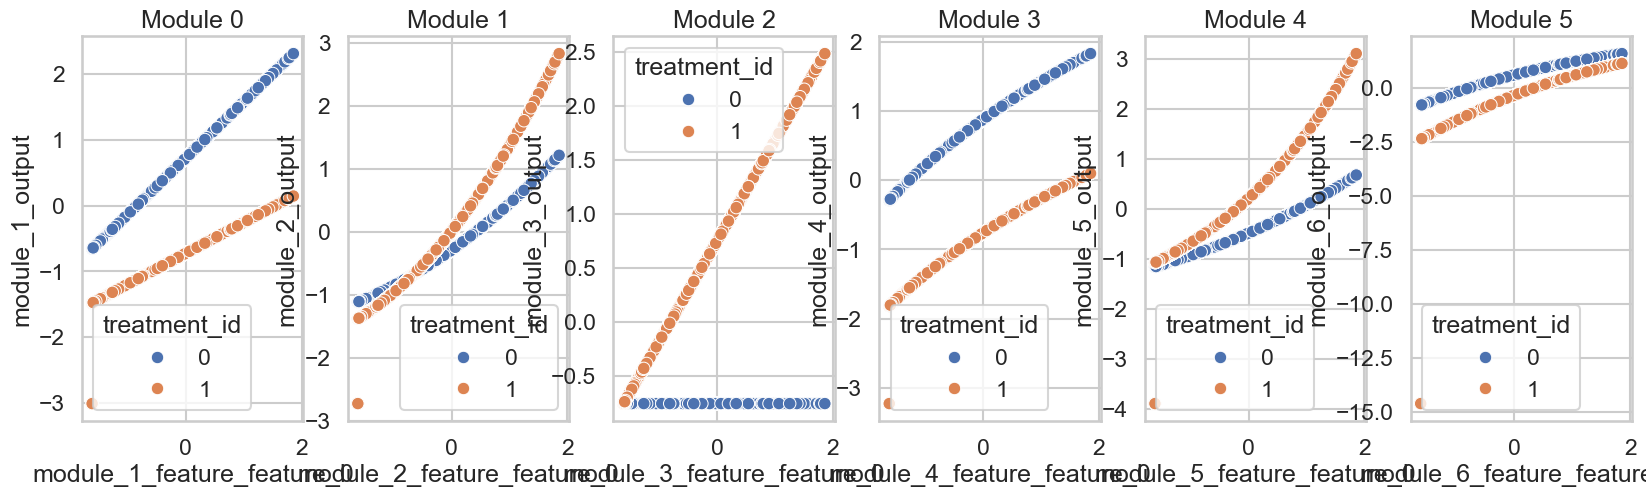

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("talk")
max_modules = 6
fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
for i in range(max_modules):
    sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"module_{i+1}_output", data=data, ax=ax[i],hue="treatment_id")
    ax[i].set_title(f"Module {i}")

# fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
# for i in range(max_modules):
#     sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"expert_output_" + str(i), data=data, ax=ax[i],hue="treatment_id")
#     ax[i].set_title(f"Module {i}")


In [6]:
X = test_df[covariates].values
X_1 = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
X_1 = torch.tensor(X_1, dtype=torch.float32)
# predicted_effect_1 = model(X_1).cpu().numpy()






# Results Analysis

In [22]:
# Save results and CSVs
results_path = f"{main_dir}/results/results_{args.data_dist}_{args.module_function_type}_{args.composition_type}_covariates_shared_{args.covariates_shared}_underlying_model_{args.underlying_model_class}_use_subset_features_{args.use_subset_features}_systematic_{args.systematic}"
os.makedirs(results_path, exist_ok=True)
with open(f"{results_path}/results_{args.num_modules}_{args.num_feature_dimensions}_scale_{args.scale}.json", "w") as f:
    json.dump(results, f)



results_csv_folder = f"{main_dir}/results/csvs"
os.makedirs(results_csv_folder, exist_ok=True)
# Save combined_df_test and module_csvs here
additive_combined_test_df.to_csv(f"{results_csv_folder}/additive_combined_test_df.csv", index=False)
for module_file, module_csv in module_csvs.items():
    module_csv.to_csv(f"{results_csv_folder}/{module_file}.csv", index=False)

print(f"Results saved at {results_path}")
print(f"CSVs saved at {results_csv_folder}")
print("Done!")

2024-09-22 03:07:47.829116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Results saved at /Users/ppruthi/research/compositional_models/compositional_models_cate/domains/synthetic_data/results/results_uniform_quadratic_parallel_covariates_shared_False_underlying_model_MLP_use_subset_features_False_systematic_False
CSVs saved at /Users/ppruthi/research/compositional_models/compositional_models_cate/domains/synthetic_data/results/csvs
Done!


In [23]:
def scatter_plot(df, x, y, title, xlabel, ylabel, save_path=None):
    plt.scatter(df[x], df[y])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [24]:
combined_df_test

,ground_truth_effect,estimated_effect
0,-0.293698,-0.311285
1,-0.641127,-0.642452
2,-0.612727,-0.604818
3,0.239012,0.246677
4,-0.717167,-0.693429
...,...,...
162,-0.719175,-0.764137
163,0.595639,0.640840
164,1.285423,1.451030
165,-0.269334,-0.208952


In [16]:
## Confirming risk decomposition of the additive parallel composition model. 
results_csv_folder = f"{main_dir}/results/csvs"
# hl_filepath = f"{results_csv_folder}/combined_df_{args.data_dist}_{args.module_function_type}_{args.composition_type}_covariates_shared_{args.covariates_shared}_underlying_model_{args.underlying_model_class}_use_subset_features_{args.use_subset_features}_systematic_{args.systematic}.csv"
hl_filepath = f"{results_csv_folder}/additive_combined_test_df.csv"
combined_df_test = pd.read_csv(hl_filepath)
# drop unnamed columns

pehe_baseline_test = pehe(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_baseline"])
pehe_additive_test = pehe(combined_df_test["ground_truth_effect_additive"], combined_df_test["estimated_effect_additive"])
pehe_moe_test = pehe(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_moe"])

print(f"PEHE Baseline: {pehe_baseline_test}")   
print(f"PEHE Additive: {pehe_additive_test}")
print(f"PEHE MoE: {pehe_moe_test}")

# R2 score
r2_baseline_test = r2_score(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_baseline"])
r2_additive_test = r2_score(combined_df_test["ground_truth_effect_additive"], combined_df_test["estimated_effect_additive"])
r2_moe_test = r2_score(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_moe"])

print(f"R2 Baseline: {r2_baseline_test}")
print(f"R2 Additive: {r2_additive_test}")
print(f"R2 MoE: {r2_moe_test}")

# scatter plot
scatter_plot(combined_df_test, "ground_truth_effect_baseline", "estimated_effect_baseline", "Baseline", "Ground Truth Effect", "Estimated Effect", save_path=None)
scatter_plot(combined_df_test, "ground_truth_effect_additive", "estimated_effect_additive", "Additive", "Ground Truth Effect", "Estimated Effect", save_path=None)
scatter_plot(combined_df_test, "ground_truth_effect_baseline", "estimated_effect_moe", "MoE", "Ground Truth Effect", "Estimated Effect", save_path=None)


KeyError: 'ground_truth_effect_baseline'

# Data Analysis

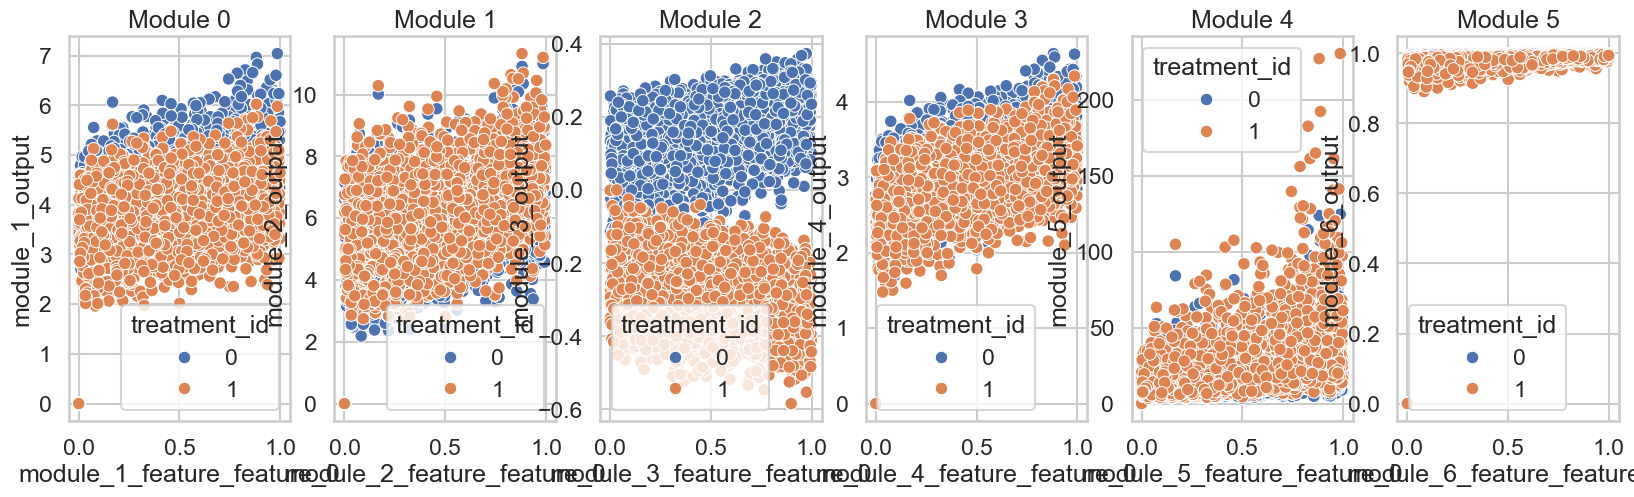

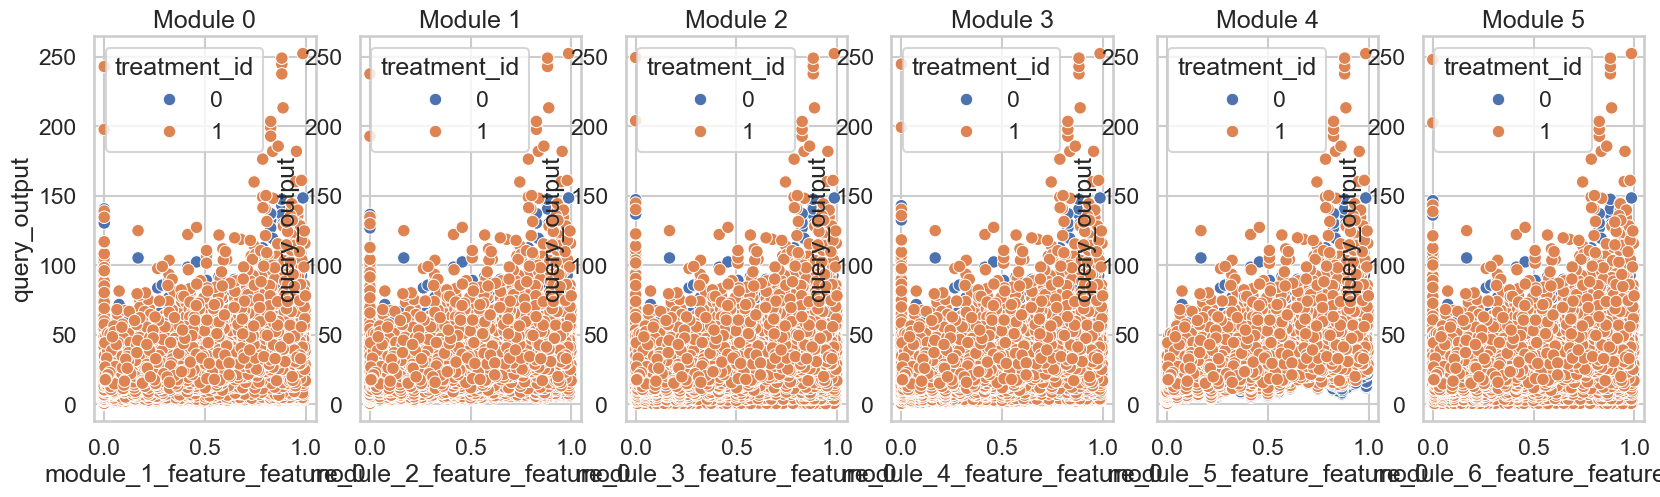

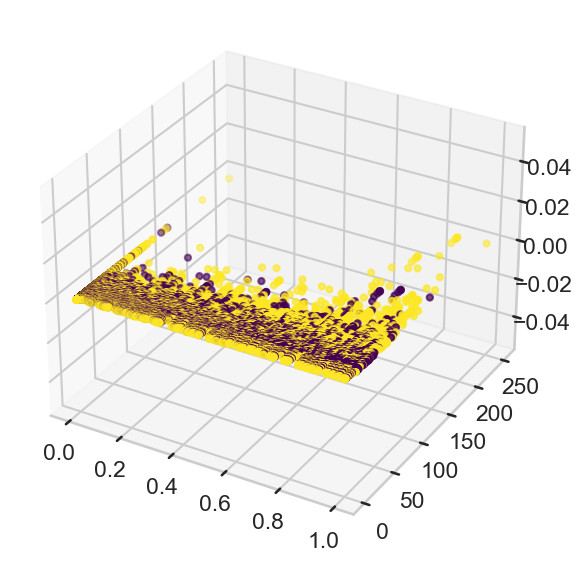

In [5]:
# Hypotheses to test
# 1. Each component output is a quadratic function of the input features.
# 2. Plot final output vs input features.

# Hypothesis 1
# plot 1
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("talk")
max_modules = 6
fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
for i in range(max_modules):
    sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"module_{i+1}_output", data=data, ax=ax[i],hue="treatment_id")
    ax[i].set_title(f"Module {i}")

fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
for i in range(max_modules):
    sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"query_output", data=data, ax=ax[i],hue="treatment_id")
    ax[i].set_title(f"Module {i}")

# Have a 3D plot for two features and one output
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["module_1_feature_feature_0"], data["query_output"], c=data["treatment_id"], cmap='viridis')



In [11]:
train_df

,query_id,treatment_id,tree_depth,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,query_output,estimated_effect
0,0.0,0.0,2.0,0.093108,0.971656,0.483860,0.242523,0.531124,0.285544,9.031499,-0.162952
1,1.0,0.0,2.0,0.417022,0.720324,0.000114,0.302333,0.146756,0.092339,6.577843,1.048488
2,2.0,0.0,2.0,0.435995,0.025926,0.549662,0.435322,0.420368,0.330335,7.781564,0.186701
3,3.0,1.0,2.0,0.550798,0.708148,0.290905,0.510828,0.892947,0.896293,12.988309,13.468414
4,4.0,0.0,2.0,0.967030,0.547232,0.972684,0.714816,0.697729,0.216089,13.673847,6.016727
...,...,...,...,...,...,...,...,...,...,...,...
9983,9983.0,0.0,6.0,0.348526,0.372211,0.444543,0.579550,0.964057,0.961205,50.246906,4.692570
9984,9984.0,1.0,6.0,0.619305,0.057944,0.442426,0.677261,0.066017,0.326359,21.172132,-0.077519
9985,9985.0,0.0,6.0,0.771148,0.074757,0.526310,0.975088,0.992226,0.465135,59.687623,-1.491791
9986,9986.0,0.0,6.0,0.559446,0.761492,0.244532,0.771689,0.354472,0.796697,40.933231,5.057709


In [12]:
test_df

,query_id,treatment_id,tree_depth,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,query_output,estimated_effect
18,18.0,0.0,2.0,0.650374,0.505453,0.878601,0.181840,0.852233,0.750136,13.209397,20.741325
20,20.0,0.0,2.0,0.588131,0.897714,0.891531,0.815837,0.035890,0.691758,13.682051,6.217636
55,55.0,1.0,2.0,0.093108,0.971656,0.483860,0.242523,0.531124,0.285544,9.218278,-0.162952
131,131.0,0.0,2.0,0.650154,0.948109,0.388029,0.641296,0.690512,0.126609,11.324579,3.709873
134,134.0,0.0,2.0,0.417022,0.720324,0.000114,0.302333,0.146756,0.092339,3.069162,1.048488
...,...,...,...,...,...,...,...,...,...,...,...
9889,9889.0,0.0,6.0,0.428602,0.454515,0.626081,0.301348,0.565366,0.449860,27.384324,2.785248
9896,9896.0,0.0,6.0,0.690231,0.767943,0.260554,0.790513,0.774354,0.853626,64.868062,11.238583
9906,9906.0,1.0,6.0,0.188134,0.238688,0.930562,0.031910,0.419589,0.108174,17.111441,0.126028
9915,9915.0,0.0,6.0,0.450189,0.566355,0.659705,0.386724,0.588486,0.991290,44.343914,8.352009


In [7]:
data

,query_id,treatment_id,tree_depth,num_module_1,num_module_2,num_module_3,num_module_4,num_module_5,num_module_6,module_1_feature_feature_0,...,module_6_feature_feature_3,module_6_feature_feature_4,module_6_feature_feature_5,module_1_output,module_2_output,module_3_output,module_4_output,module_5_output,module_6_output,query_output
0,0,0,2,1,1,0,0,0,0,0.093108,...,0.000000,0.000000,0.000000,3.847837,5.183662,0.000000,0.000000,0.000000,0.000000,9.031499
1,1,0,2,1,1,0,0,0,0,0.417022,...,0.000000,0.000000,0.000000,3.010831,3.567012,0.000000,0.000000,0.000000,0.000000,6.577843
2,2,0,2,1,1,0,0,0,0,0.435995,...,0.000000,0.000000,0.000000,3.744251,4.037312,0.000000,0.000000,0.000000,0.000000,7.781564
3,3,0,2,1,1,0,0,0,0,0.550798,...,0.000000,0.000000,0.000000,5.379194,7.701154,0.000000,0.000000,0.000000,0.000000,13.080348
4,4,0,2,1,1,0,0,0,0,0.967030,...,0.000000,0.000000,0.000000,5.744954,7.928893,0.000000,0.000000,0.000000,0.000000,13.673847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19971,9983,1,6,1,1,1,1,1,1,0.348526,...,0.579550,0.964057,0.961205,4.635078,7.830223,-0.504331,3.381554,46.062117,0.989630,62.394272
19972,9984,1,6,1,1,1,1,1,1,0.619305,...,0.677261,0.066017,0.326359,2.865835,4.327131,-0.136564,2.560306,10.588483,0.966940,21.172132
19973,9985,1,6,1,1,1,1,1,1,0.771148,...,0.975088,0.992226,0.465135,4.371994,8.060322,-0.422715,3.487990,53.108332,0.990885,69.596807
19974,9986,1,6,1,1,1,1,1,1,0.559446,...,0.771689,0.354472,0.796697,4.380662,6.894390,-0.305474,3.364087,35.494347,0.989060,50.817072


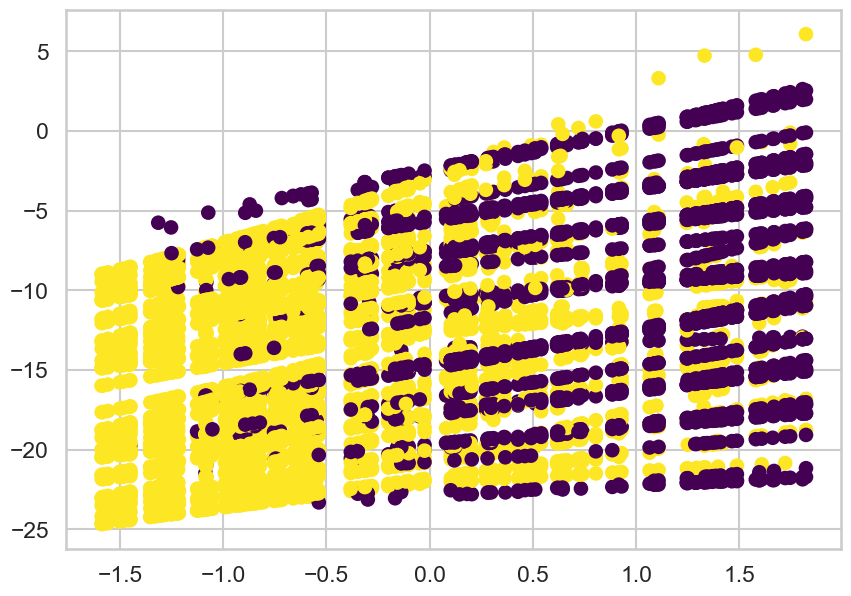

In [24]:
# Hypotheses to test
# 1. Each component output is a quadratic function of the input features.
# 2. Plot final output vs input features.

# Hypothesis 1
# plot 1
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("talk")
max_modules = 6
# fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))

# Have a 3D plot for two features and one output
fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')
plt.scatter(train_df["feature_0"],train_df["query_output"], c=train_df["treatment_id"], cmap='viridis')



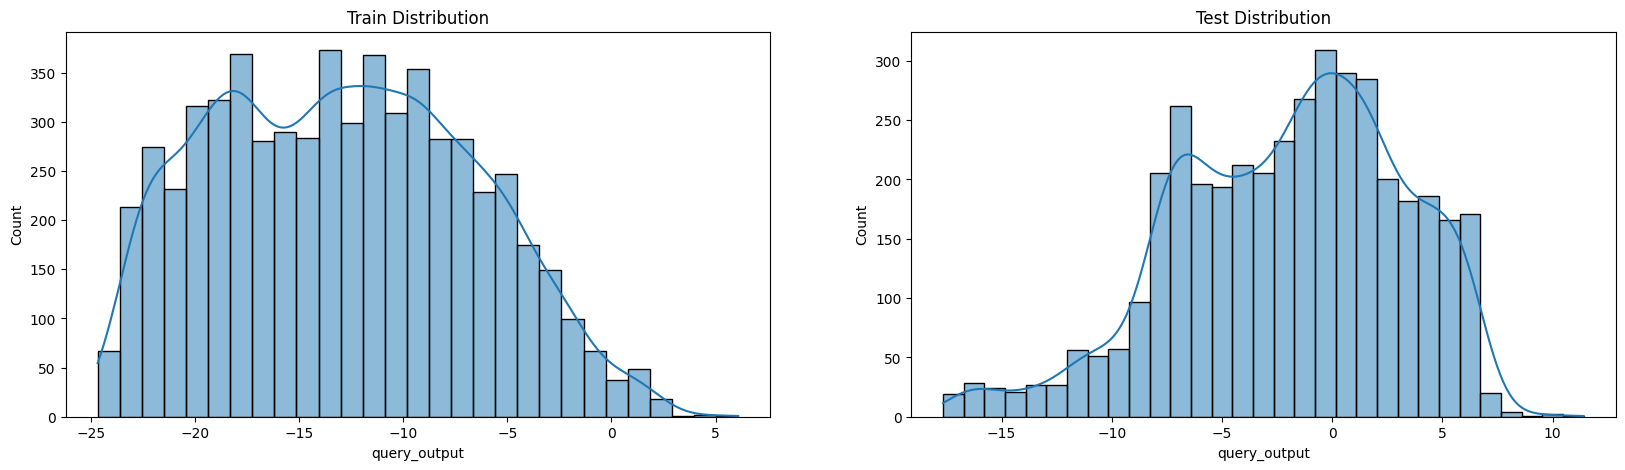

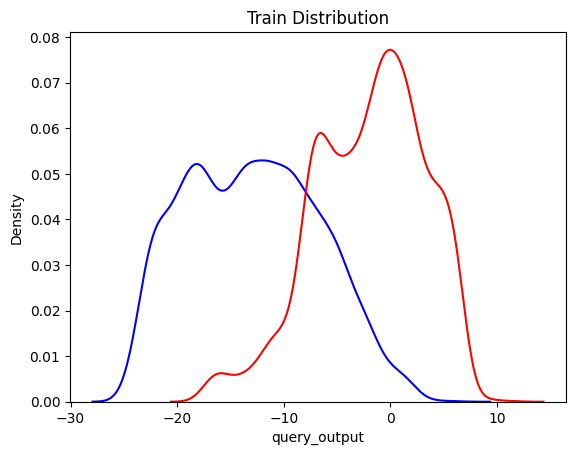

In [19]:
# plot distribution of the output for train and test df in the same plot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(train_df["query_output"], ax=ax[0], kde=True)
ax[0].set_title("Train Distribution")
sns.histplot(test_df["query_output"], ax=ax[1], kde=True)
ax[1].set_title("Test Distribution")
plt.show()

# plot distribution of the output for train and test df in the same plot
# scale the distribution by dividing by the number of samples
sns.kdeplot(train_df["query_output"], label="Train", color="blue")
sns.kdeplot(test_df["query_output"], label="Test", color="red")


plt.title("Train Distribution")
plt.show()





In [9]:
train_df

,feature_0,query_id,treatment_id,tree_depth,query_output,num_module_1,num_module_2,num_module_3,num_module_4,num_module_5,num_module_6,estimated_effect
0,-1.294907,0.0,1.0,2.0,-21.959842,1.0,1.0,0.0,0.0,0.0,0.0,-0.999929
1,-0.167721,1.0,1.0,2.0,-20.435439,1.0,1.0,0.0,0.0,0.0,0.0,-1.051449
2,-0.101697,2.0,0.0,2.0,-19.253727,1.0,1.0,0.0,0.0,0.0,0.0,-1.046946
3,0.297805,3.0,0.0,2.0,-18.659106,1.0,1.0,0.0,0.0,0.0,0.0,-0.993319
4,1.746249,4.0,1.0,2.0,-16.715494,1.0,1.0,0.0,0.0,0.0,0.0,-0.350494
...,...,...,...,...,...,...,...,...,...,...,...,...
5985,1.396929,5985.0,0.0,4.0,-3.398187,0.0,0.0,1.0,1.0,1.0,1.0,-0.774532
5986,0.366239,5986.0,0.0,4.0,-4.177942,0.0,0.0,1.0,1.0,1.0,1.0,-1.696994
5987,-1.126690,5987.0,0.0,4.0,-5.615623,0.0,0.0,1.0,1.0,1.0,1.0,-2.569038
5988,0.643389,5988.0,0.0,4.0,-3.957610,0.0,0.0,1.0,1.0,1.0,1.0,-1.472056


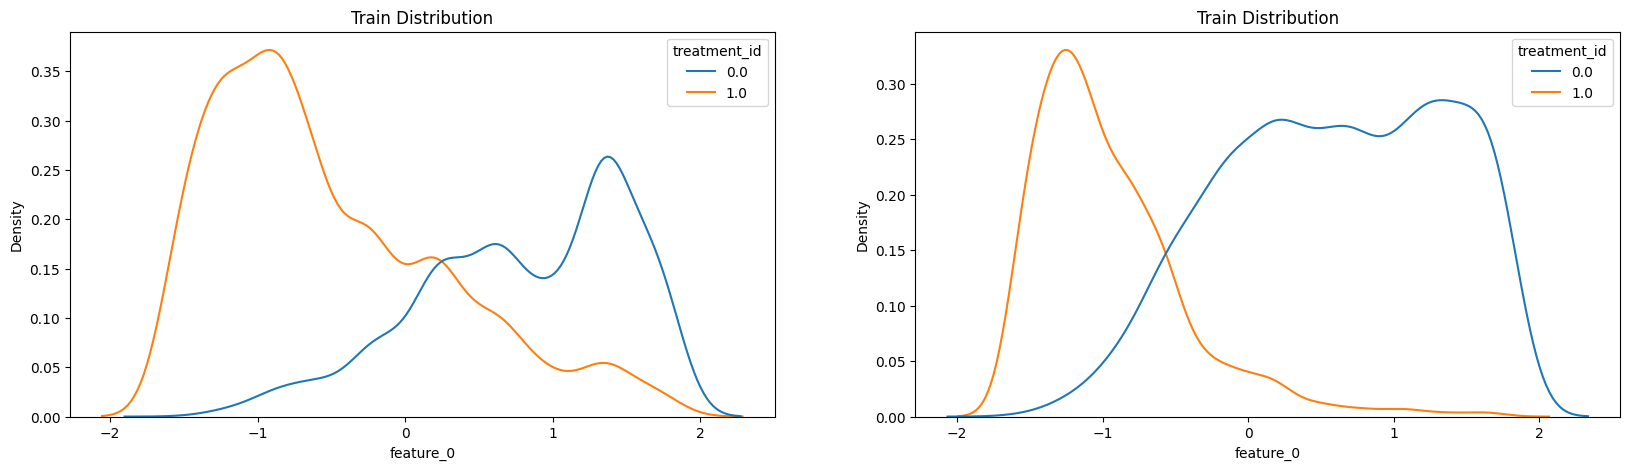

In [20]:
# plot distribution of the covariates for train df with treatment id
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.kdeplot(data=train_df, x="feature_0", hue="treatment_id", label="Train", color="blue", ax=ax[0])
ax[0].set_title("Train Distribution")
sns.kdeplot(data=test_df, x="feature_0", hue="treatment_id", label="Test", color="red", ax=ax[1])
ax[1].set_title("Test Distribution")


plt.title("Train Distribution")
plt.show()

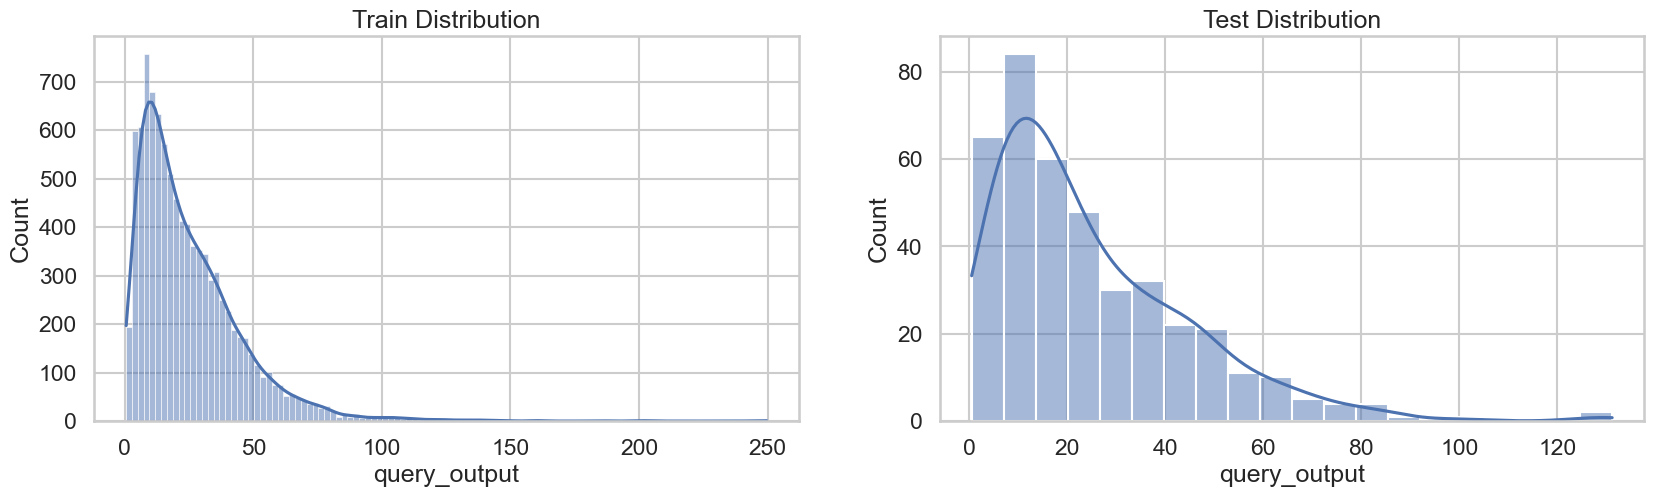

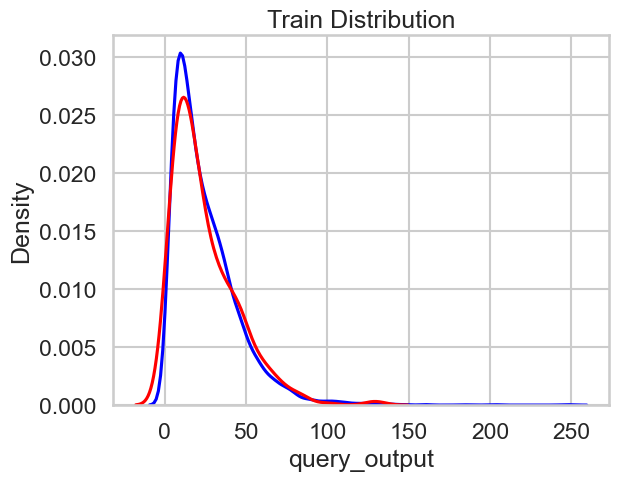

In [10]:
# plot distribution of the output for train and test df in the same plot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(train_df["query_output"], ax=ax[0], kde=True)
ax[0].set_title("Train Distribution")
sns.histplot(test_df["query_output"], ax=ax[1], kde=True)
ax[1].set_title("Test Distribution")
plt.show()

# plot distribution of the output for train and test df in the same plot
# scale the distribution by dividing by the number of samples
sns.kdeplot(train_df["query_output"], label="Train", color="blue")
sns.kdeplot(test_df["query_output"], label="Test", color="red")
plt.title("Train Distribution")
plt.show()





In [4]:
train_df

,query_id,treatment_id,tree_depth,feature_0,query_output,estimated_effect
0,0.0,1.0,6.0,2.332094,7.601424,-0.822095
1,1.0,0.0,6.0,1.837576,6.601998,-0.255748
2,2.0,0.0,6.0,4.455093,20.304125,-6.821352
3,3.0,1.0,6.0,2.381806,7.721851,-0.888784
4,4.0,0.0,6.0,0.282987,3.614654,-0.285166
...,...,...,...,...,...,...
9994,9994.0,1.0,6.0,-1.242620,0.796382,-4.102654
9995,9995.0,0.0,6.0,1.952960,6.971097,-0.372728
9996,9996.0,1.0,6.0,2.662555,8.422631,-1.466716
9998,9998.0,1.0,6.0,-2.571321,-1.061101,-10.133957


In [5]:
test_df

,query_id,treatment_id,tree_depth,feature_0,query_output,estimated_effect
13,13.0,1.0,6.0,-1.950719,-0.242397,-7.048714
21,21.0,0.0,6.0,1.725250,6.262990,-0.150230
39,39.0,0.0,6.0,1.461894,5.546099,0.051443
45,45.0,0.0,6.0,2.044264,7.278221,-0.471660
71,71.0,0.0,6.0,2.403060,8.614803,-0.920901
...,...,...,...,...,...,...
9894,9894.0,1.0,6.0,1.428701,5.579292,0.060589
9901,9901.0,1.0,6.0,-0.199435,2.485306,-0.977410
9922,9922.0,0.0,6.0,2.375805,8.505987,-0.880636
9980,9980.0,1.0,6.0,-1.763250,0.022115,-6.207575


# Data baseline model 

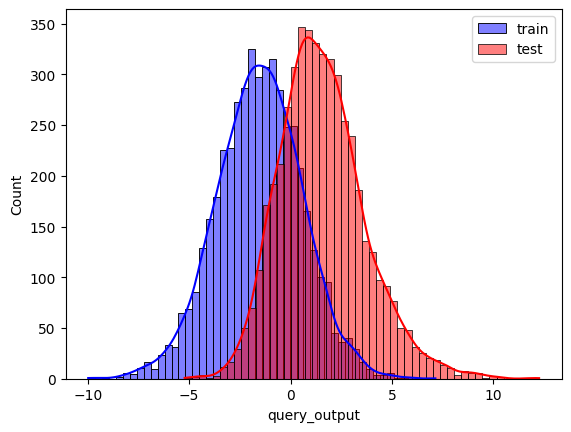

In [5]:
# plot feature distribution of module_1_feature_feature_0
import seaborn as sns
# sns.histplot(train_df[high_level_output], bins=50, color="blue", label="train", kde=True)
# sns.histplot(test_df[high_level_output], bins=50, color="red", label="test", kde=True)

# have two histograms based on treatment
sns.histplot(train_df[train_df["treatment_id"]==0]["query_output"], bins=50, color="blue", label="train", kde=True)
sns.histplot(train_df[train_df["treatment_id"]==1]["query_output"], bins=50, color="red", label="test", kde=True)

plt.legend()




# sns.histplot(data[high_level_output], bins=50, color="green")

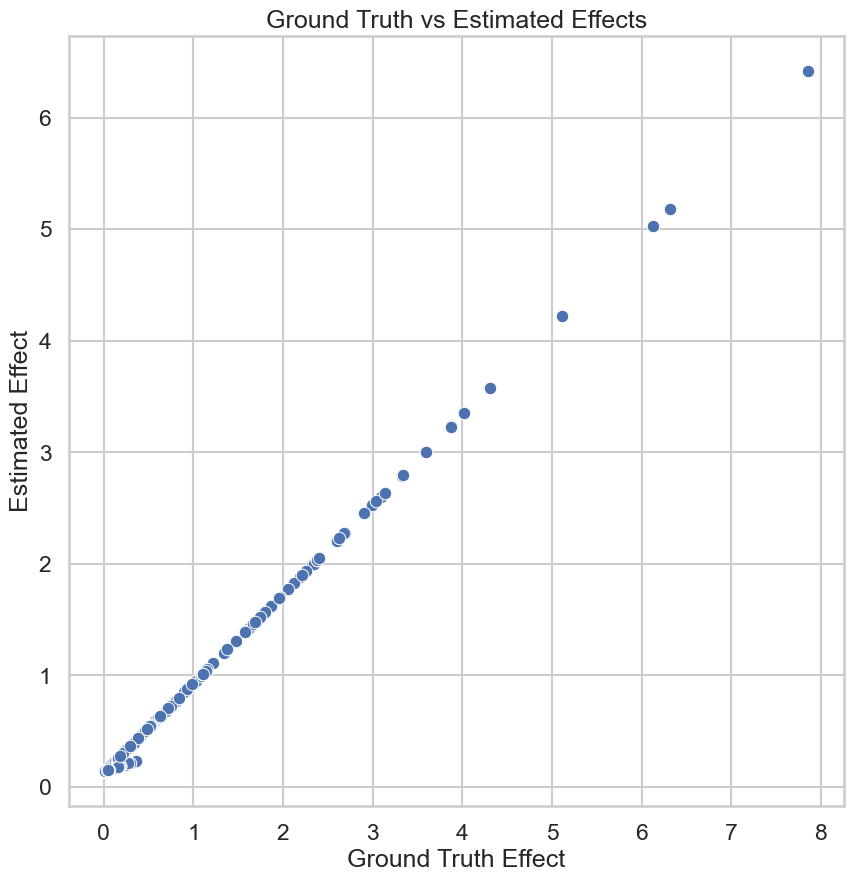

In [55]:
# scatter plot of ground truth vs estimated effects
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x="ground_truth_effect", y="estimated_effect", data=baseline_combined_df, ax=ax)
ax.set_xlabel("Ground Truth Effect")
ax.set_ylabel("Estimated Effect")
ax.set_title("Ground Truth vs Estimated Effects")

plt.show()

